# Cambridge Spark Hackathon - March 2023

Source of the original dataset: https://github.com/nshomron/covidpred

### Review of the raw data structure

In [1]:
# Importing required packages
import pandas as pd
import numpy as np

# df = pd.read_csv(
#     "./data/corona_tested_individuals_ver_006.english.csv",
#     parse_dates=["test_date"]
#     # index_col=["test_date"]
# )

# Read in zip file
data_path = "./data/corona_tested_individuals_ver_006.english.csv.zip"
raw_data_df = pd.read_csv(
    data_path,
    compression="zip",
    na_values=["None","none","Other","other"],
    parse_dates=["test_date"]
)

# First and last 2 rows
raw_data_df.head(2), raw_data_df.tail(2)

C:\Users\lturakulov\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(   test_date  cough  fever  sore_throat  shortness_of_breath  head_ache  \
 0 2020-04-30    0.0    0.0          0.0                  0.0        0.0   
 1 2020-04-30    1.0    0.0          0.0                  0.0        0.0   
 
   corona_result age_60_and_above  gender test_indication  
 0      negative              NaN  female             NaN  
 1      negative              NaN  female             NaN  ,
         test_date  cough  fever  sore_throat  shortness_of_breath  head_ache  \
 278846 2020-03-11    0.0    0.0          0.0                  0.0        0.0   
 278847 2020-03-11    0.0    0.0          0.0                  0.0        0.0   
 
        corona_result age_60_and_above gender test_indication  
 278846           NaN              NaN    NaN             NaN  
 278847      negative              NaN    NaN             NaN  )

In [2]:
# Checking dataframe structure
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   test_date            278848 non-null  datetime64[ns]
 1   cough                278596 non-null  float64       
 2   fever                278596 non-null  float64       
 3   sore_throat          278847 non-null  float64       
 4   shortness_of_breath  278847 non-null  float64       
 5   head_ache            278847 non-null  float64       
 6   corona_result        274956 non-null  object        
 7   age_60_and_above     151528 non-null  object        
 8   gender               259285 non-null  object        
 9   test_indication      36107 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 21.3+ MB


In [3]:
# Checking dataframe numeric values
raw_data_df.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache
count,278596.000000,278596.000000,278847.000000,278847.000000,278847.000000
mean,0.151574,0.078077,0.006907,0.005655,0.008657
std,0.358608,0.268294,0.082821,0.074990,0.092640
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Unique values of columns
unique_values = [
    raw_data_df.cough.value_counts(),
    raw_data_df.fever.value_counts(),
    raw_data_df.sore_throat.value_counts(),
    raw_data_df.shortness_of_breath.value_counts(),
    raw_data_df.head_ache.value_counts(),
    raw_data_df.corona_result.value_counts(),
    raw_data_df.age_60_and_above.value_counts(),
    raw_data_df.gender.value_counts(),
    raw_data_df.test_indication.value_counts()
]
unique_values

[0.0    236368
 1.0     42228
 Name: cough, dtype: int64,
 0.0    256844
 1.0     21752
 Name: fever, dtype: int64,
 0.0    276921
 1.0      1926
 Name: sore_throat, dtype: int64,
 0.0    277270
 1.0      1577
 Name: shortness_of_breath, dtype: int64,
 0.0    276433
 1.0      2414
 Name: head_ache, dtype: int64,
 negative    260227
 positive     14729
 Name: corona_result, dtype: int64,
 No     125703
 Yes     25825
 Name: age_60_and_above, dtype: int64,
 female    130158
 male      129127
 Name: gender, dtype: int64,
 Abroad                    25468
 Contact with confirmed    10639
 Name: test_indication, dtype: int64]

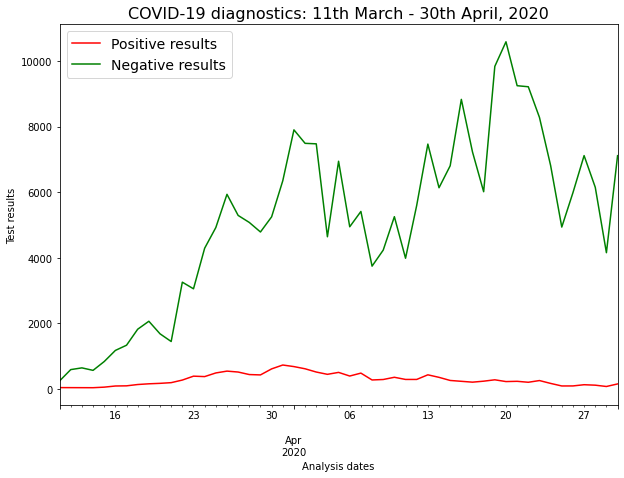

In [5]:
# Visualising Corona test result changes over time
import matplotlib.pyplot as plt

df_results_pos = raw_data_df[raw_data_df.corona_result == "positive"].groupby(by="test_date").count()
df_results_neg = raw_data_df[raw_data_df.corona_result == "negative"].groupby(by="test_date").count()

plt.figure(figsize=(10, 7))
df_results_pos.corona_result.plot(label="Positive results", c="r")
df_results_neg.corona_result.plot(label="Negative results", c="g")
plt.xlabel("Analysis dates")
plt.ylabel("Test results")
plt.title("COVID-19 diagnostics: 11th March - 30th April, 2020", fontsize=16)
plt.legend(fontsize=14);

Dataset is skewed and there is a growth tendency in the number of "negative" results, which may be explained by the increase of mast testing and public access to the home testing kits.

There are drops in the number of cases during the first and last weeks of Aptil. Cause needs to be correlated with external open sources, e.g. lockdown announcements, vaccination cycles, etc.

### Data cleansing

Rationale for value / column drops:
- Test dateis for 51 days, so will be difficult to identify seasonality patterns;
- Age and gender columns have significant gaps, with ~20K records without answers;
- Age and gender may contribute higher to the seriousness of side effects and recovery process, amd probably less to Covid tes result's positive or negative outcomes;
- "Other" values in test_indication and corona_result columns are less meaningful.

In [6]:
# Turn test_indication in boolean
raw_data_df.test_indication = raw_data_df.test_indication=="Contact with confirmed"
raw_data_df.rename(columns={"test_indication":"contact_with_confirmed"},inplace=True)

# Remove unwanted columns
raw_data_df = raw_data_df.drop(["test_date","age_60_and_above","gender"],axis=1)

# Remove Nan values from corona_result
raw_data_df = raw_data_df[raw_data_df["corona_result"].isin(["positive","negative"])]
raw_data_df.corona_result = raw_data_df.corona_result == "positive"
raw_data_df.rename(columns={"corona_result":"label_corona_result"},inplace=True)

# Dropping raws with NaN values
raw_data_df = raw_data_df.dropna(axis=0)

# Create target dataframe for ML training
raw_data_df = raw_data_df[[
    "cough",
    "fever",
    "sore_throat",
    "shortness_of_breath",
    "head_ache",
    "contact_with_confirmed",
    "label_corona_result"
]]
data_df = raw_data_df.copy()

In [7]:
# Checking cleansed dataframe
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274702 entries, 0 to 278847
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cough                   274702 non-null  float64
 1   fever                   274702 non-null  float64
 2   sore_throat             274702 non-null  float64
 3   shortness_of_breath     274702 non-null  float64
 4   head_ache               274702 non-null  float64
 5   contact_with_confirmed  274702 non-null  bool   
 6   label_corona_result     274702 non-null  bool   
dtypes: bool(2), float64(5)
memory usage: 13.1 MB


In [8]:
# Unique values of columns
cleansed_unique_values = [
    data_df.cough.value_counts(),
    data_df.fever.value_counts(),
    data_df.sore_throat.value_counts(),
    data_df.shortness_of_breath.value_counts(),
    data_df.head_ache.value_counts(),
    data_df.contact_with_confirmed.value_counts(),
    data_df.label_corona_result.value_counts()
]
cleansed_unique_values

[0.0    233133
 1.0     41569
 Name: cough, dtype: int64,
 0.0    253328
 1.0     21374
 Name: fever, dtype: int64,
 0.0    272814
 1.0      1888
 Name: sore_throat, dtype: int64,
 0.0    273156
 1.0      1546
 Name: shortness_of_breath, dtype: int64,
 0.0    272325
 1.0      2377
 Name: head_ache, dtype: int64,
 False    264235
 True      10467
 Name: contact_with_confirmed, dtype: int64,
 False    260008
 True      14694
 Name: label_corona_result, dtype: int64]

### Data visualisation

In [9]:
data_df

,cough,fever,sore_throat,shortness_of_breath,head_ache,contact_with_confirmed,label_corona_result
0,0.0,0.0,0.0,0.0,0.0,False,False
1,1.0,0.0,0.0,0.0,0.0,False,False
2,0.0,1.0,0.0,0.0,0.0,False,False
3,1.0,0.0,0.0,0.0,0.0,False,False
4,1.0,0.0,0.0,0.0,0.0,False,False
...,...,...,...,...,...,...,...
278842,0.0,0.0,0.0,0.0,0.0,False,False
278843,0.0,0.0,0.0,0.0,0.0,False,False
278844,0.0,0.0,0.0,0.0,0.0,False,False
278845,0.0,0.0,0.0,0.0,0.0,True,True


In [10]:
data_df = data_df.astype(int)
data_df

,cough,fever,sore_throat,shortness_of_breath,head_ache,contact_with_confirmed,label_corona_result
0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
278842,0,0,0,0,0,0,0
278843,0,0,0,0,0,0,0
278844,0,0,0,0,0,0,0
278845,0,0,0,0,0,1,1


In [11]:
# Correlation matrix
corrM = data_df.corr()
corrM.style.background_gradient(cmap='coolwarm')

,cough,fever,sore_throat,shortness_of_breath,head_ache,contact_with_confirmed,label_corona_result
cough,1.000000,0.453797,0.115613,0.106330,0.116730,0.196275,0.196763
fever,0.453797,1.000000,0.122233,0.125840,0.169774,0.180061,0.266633
sore_throat,0.115613,0.122233,1.000000,0.195181,0.323343,0.180226,0.278462
shortness_of_breath,0.106330,0.125840,0.195181,1.000000,0.202082,0.138045,0.233417
head_ache,0.116730,0.169774,0.323343,0.202082,1.000000,0.228591,0.367324
contact_with_confirmed,0.196275,0.180061,0.180226,0.138045,0.228591,1.000000,0.570262
label_corona_result,0.196763,0.266633,0.278462,0.233417,0.367324,0.570262,1.000000


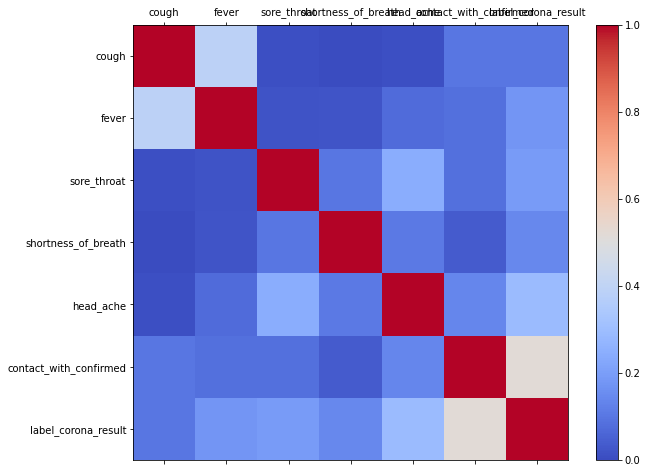

In [12]:
# Visualise with Matplotlib

# Main matrix
fig, ax = plt.subplots(figsize=(10, 8))
ax.matshow(corrM, cmap='coolwarm')
plt.xticks(range(len(corrM.columns)), corrM.columns)
plt.yticks(range(len(corrM.columns)), corrM.columns)

# Colour bar
sm = plt.cm.ScalarMappable(
    cmap='coolwarm',
    norm=plt.Normalize(vmin=0, vmax=1)
)
cb = plt.colorbar(sm)
cb.ax.tick_params(labelsize=10);

<AxesSubplot:>

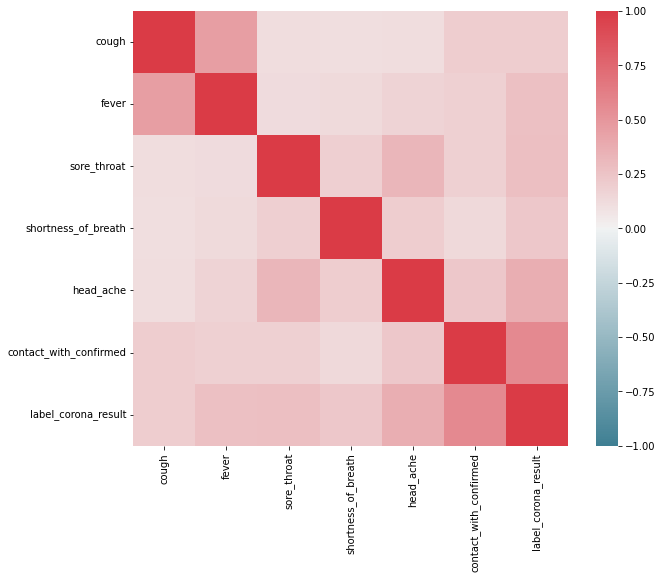

In [13]:
# Visualise with Seaborn
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrM,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

### Similar use case from the Insurance industry

Found very interesting and somehow simuilar case, where imbalanced dataset is used to detect suspicious claims in the insurance industry: https://sarit-maitra.medium.com/neural-network-to-solve-skewed-binary-class-distribution-4e2c9f2b4bbf. Adapted the code for our Hackathon dataset's specifics.

### Prepare train and test datasets

In [14]:
# Splitting dataset into Train abd Test subsets
from sklearn.model_selection import train_test_split

features = data_df.columns[:-1]
X = data_df[features]
y = data_df["label_corona_result"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(219761, 6) (219761,) (54941, 6) (54941,)


### Defining helper functions

In [15]:
# Evaluation metrics
import tensorflow as tf

METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

In [16]:
# Function to create NN model with densely connected layers
def createModel(train_data, metrics=METRICS, output_bias = None):
    # Checking bias values
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    # Creating simple dense model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            units=36, 
            activation='relu',
            input_shape=(train_data.shape[-1],)
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(units=1, activation='sigmoid', bias_initializer=output_bias),
    ])

    # Compiling the model
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=metrics,  
    )

    return model

In [17]:
# Function for the Tensorflow callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [18]:
# Function to define class weights
from sklearn.utils import class_weight

def classWeights():
    class_weights = class_weight.compute_class_weight(
        "balanced",
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights))
    # print('Class weights:', class_weights);print()
    return class_weights

### Weighted Neural Network

In [19]:
# Setting initial bias
minus, plus = np.bincount(data_df["label_corona_result"])
initial_bias = np.log([ plus / minus ])
print('Initial bias:', initial_bias); print()

# Generating weighted model
weightedModel = createModel(X_train, output_bias=initial_bias)
BATCH_SIZE = 2048
EPOCHS = 20

# steps_per_epoch = len(X_train) // BATCH_SIZE
# print('Steps per Epoch:', steps_per_epoch)

Initial bias: [-2.87327315]



In [20]:
# Getting class weights
class_weights = classWeights()
class_weights

{0: 0.5284138998961259, 1: 9.298510620292799}

In [21]:
# Training model with class weights
history = weightedModel.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_split=0.10,
    # steps_per_epoch=steps_per_epoch,
    shuffle=True,
    # verbose=1,
    class_weight=class_weights,
)

# list all data in history
# print(history.history.keys())

Epoch 1/20
97/97 [==============================] - 5s 20ms/step - loss: 0.6556 - tp: 6006.0000 - fp: 9169.0000 - tn: 177983.0000 - fn: 4626.0000 - accuracy: 0.9303 - precision: 0.3958 - recall: 0.5649 - auc: 0.8318 - prc: 0.4563 - val_loss: 0.1860 - val_tp: 14.0000 - val_fp: 0.0000e+00 - val_tn: 20792.0000 - val_fn: 1171.0000 - val_accuracy: 0.9467 - val_precision: 1.0000 - val_recall: 0.0118 - val_auc: 0.8746 - val_prc: 0.5615
Epoch 2/20
97/97 [==============================] - 1s 8ms/step - loss: 0.4644 - tp: 7681.0000 - fp: 13508.0000 - tn: 173644.0000 - fn: 2951.0000 - accuracy: 0.9168 - precision: 0.3625 - recall: 0.7224 - auc: 0.8761 - prc: 0.5497 - val_loss: 0.2112 - val_tp: 290.0000 - val_fp: 61.0000 - val_tn: 20731.0000 - val_fn: 895.0000 - val_accuracy: 0.9565 - val_precision: 0.8262 - val_recall: 0.2447 - val_auc: 0.8761 - val_prc: 0.5865
Epoch 3/20
97/97 [==============================] - 1s 10ms/step - loss: 0.4274 - tp: 7851.0000 - fp: 15032.0000 - tn: 172120.0000 - fn: 

### Model accuracy & loss

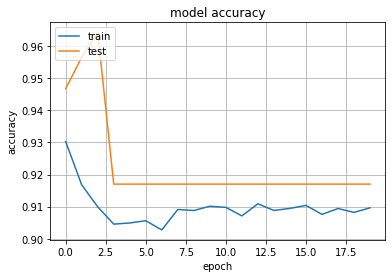

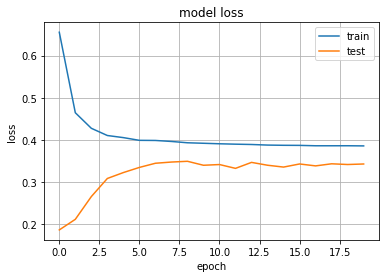

In [22]:
# Summarising history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True); plt.show()

# Summarising history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.grid(True); plt.show()

In [23]:
# Model scores
from sklearn.metrics import f1_score, cohen_kappa_score, matthews_corrcoef

predictions = weightedModel.predict(X_test, batch_size=BATCH_SIZE)
predictions = np.round(predictions.flatten())
results = weightedModel.evaluate(X_test.values, y_test.values, batch_size=BATCH_SIZE, verbose=0)

print("\nModel metrics: ----------------------")
for name, value in zip(weightedModel.metrics_names, results):
  print(name, ': ', value)

print("\nModel scores: ----------------------")
print(f'f1 score: {f1_score(y_test, predictions)}')
print(f'Mathews Correlation Coeff: {matthews_corrcoef(y_test.values, predictions)}')
print(f'Cohen Kappa: {cohen_kappa_score(y_test.values, predictions)}')

27/27 [==============================] - 0s 3ms/step

Model metrics: ----------------------
loss :  0.33745017647743225
tp :  2179.0
fp :  3694.0
tn :  48370.0
fn :  698.0
accuracy :  0.9200596809387207
precision :  0.3710199296474457
recall :  0.7573861479759216
auc :  0.8807806372642517
prc :  0.6408989429473877

Model scores: ----------------------
f1 score: 0.49805714285714286
Mathews Correlation Coeff: 0.49489031584601195
Cohen Kappa: 0.4601051646005647


### ROC (Receiver Operating Characteristic) and AUC (Area Under the Curve)

In [24]:
# ROC curve
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predictions)

In [25]:
# AUC value
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

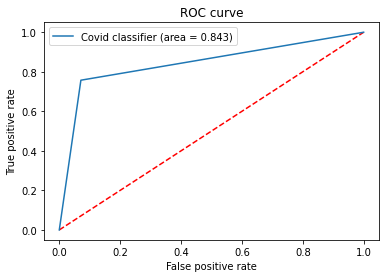

In [26]:
# Plotting the ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_keras, tpr_keras, label='Covid classifier (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Confusion Matrix

27/27 [==============================] - 0s 3ms/step
# Negative Covid results identified (True Negatives):  48370
# Negative Covid results MIS-DIAGNOSED (False Positives):  3694
# Positive Covid results MISSED (False Negatives):  698
# Positive Covid results identified (True Positives):  2179
Total number of Positive Covid results:  2877



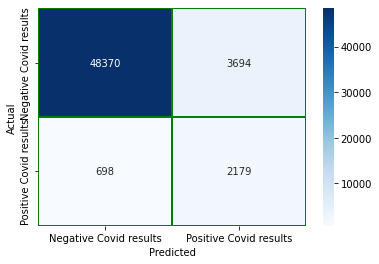

In [27]:
# Function to generate confusion matrix
from sklearn.metrics import confusion_matrix

def conf_matrix(labels, predictions, p=0.5):
    tick_labels = ["Negative Covid results", "Positive Covid results"]

    linewidths = 2
    linecolor = "Green"

    cm = confusion_matrix(labels, predictions > p)
    ax = sns.heatmap(
        cm, annot=True,
        fmt="d", cmap="Blues",
        linewidths=linewidths,
        linecolor=linecolor
    )

    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    
    print("# Negative Covid results identified (True Negatives): ", cm[0][0])
    print("# Negative Covid results MIS-DIAGNOSED (False Positives): ", cm[0][1])
    print("# Positive Covid results MISSED (False Negatives): ", cm[1][0])
    print("# Positive Covid results identified (True Positives): ", cm[1][1])
    print("Total number of Positive Covid results: ", np.sum(cm[1])); print()

model_pred = weightedModel.predict(X_test.values, batch_size=BATCH_SIZE)
conf_matrix(y_test, model_pred)